In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = "/content/drive/MyDrive/Colab Notebooks/APRENDIZAJE2"

In [ ]:
#CARGA DE LIBRERIAS Y FICHERO DE DATOS

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics import silhouette_samples, silhouette_score

blancos = pd.read_csv(f"{base_path}/train_white.csv")

In [ ]:
#DISTRIBUCION DE LOS DATOS

blancos.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000
mean,6.853880,0.277924,0.334461,6.403407,0.045601,35.374809,138.328229,0.994020,3.187205,0.489954,10.519792
std,0.837785,0.100556,0.123079,5.115891,0.021329,17.122286,42.524735,0.003025,0.150857,0.113536,1.230721
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,10.000000,0.987130,2.720000,0.220000,8.000000
25%,6.300000,0.210000,0.270000,1.700000,0.035000,23.000000,108.000000,0.991720,3.080000,0.410000,9.500000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993700,3.170000,0.480000,10.400000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996120,3.280000,0.550000,11.400000
max,14.200000,1.100000,1.660000,65.800000,0.290000,289.000000,440.000000,1.038980,3.810000,1.080000,14.200000


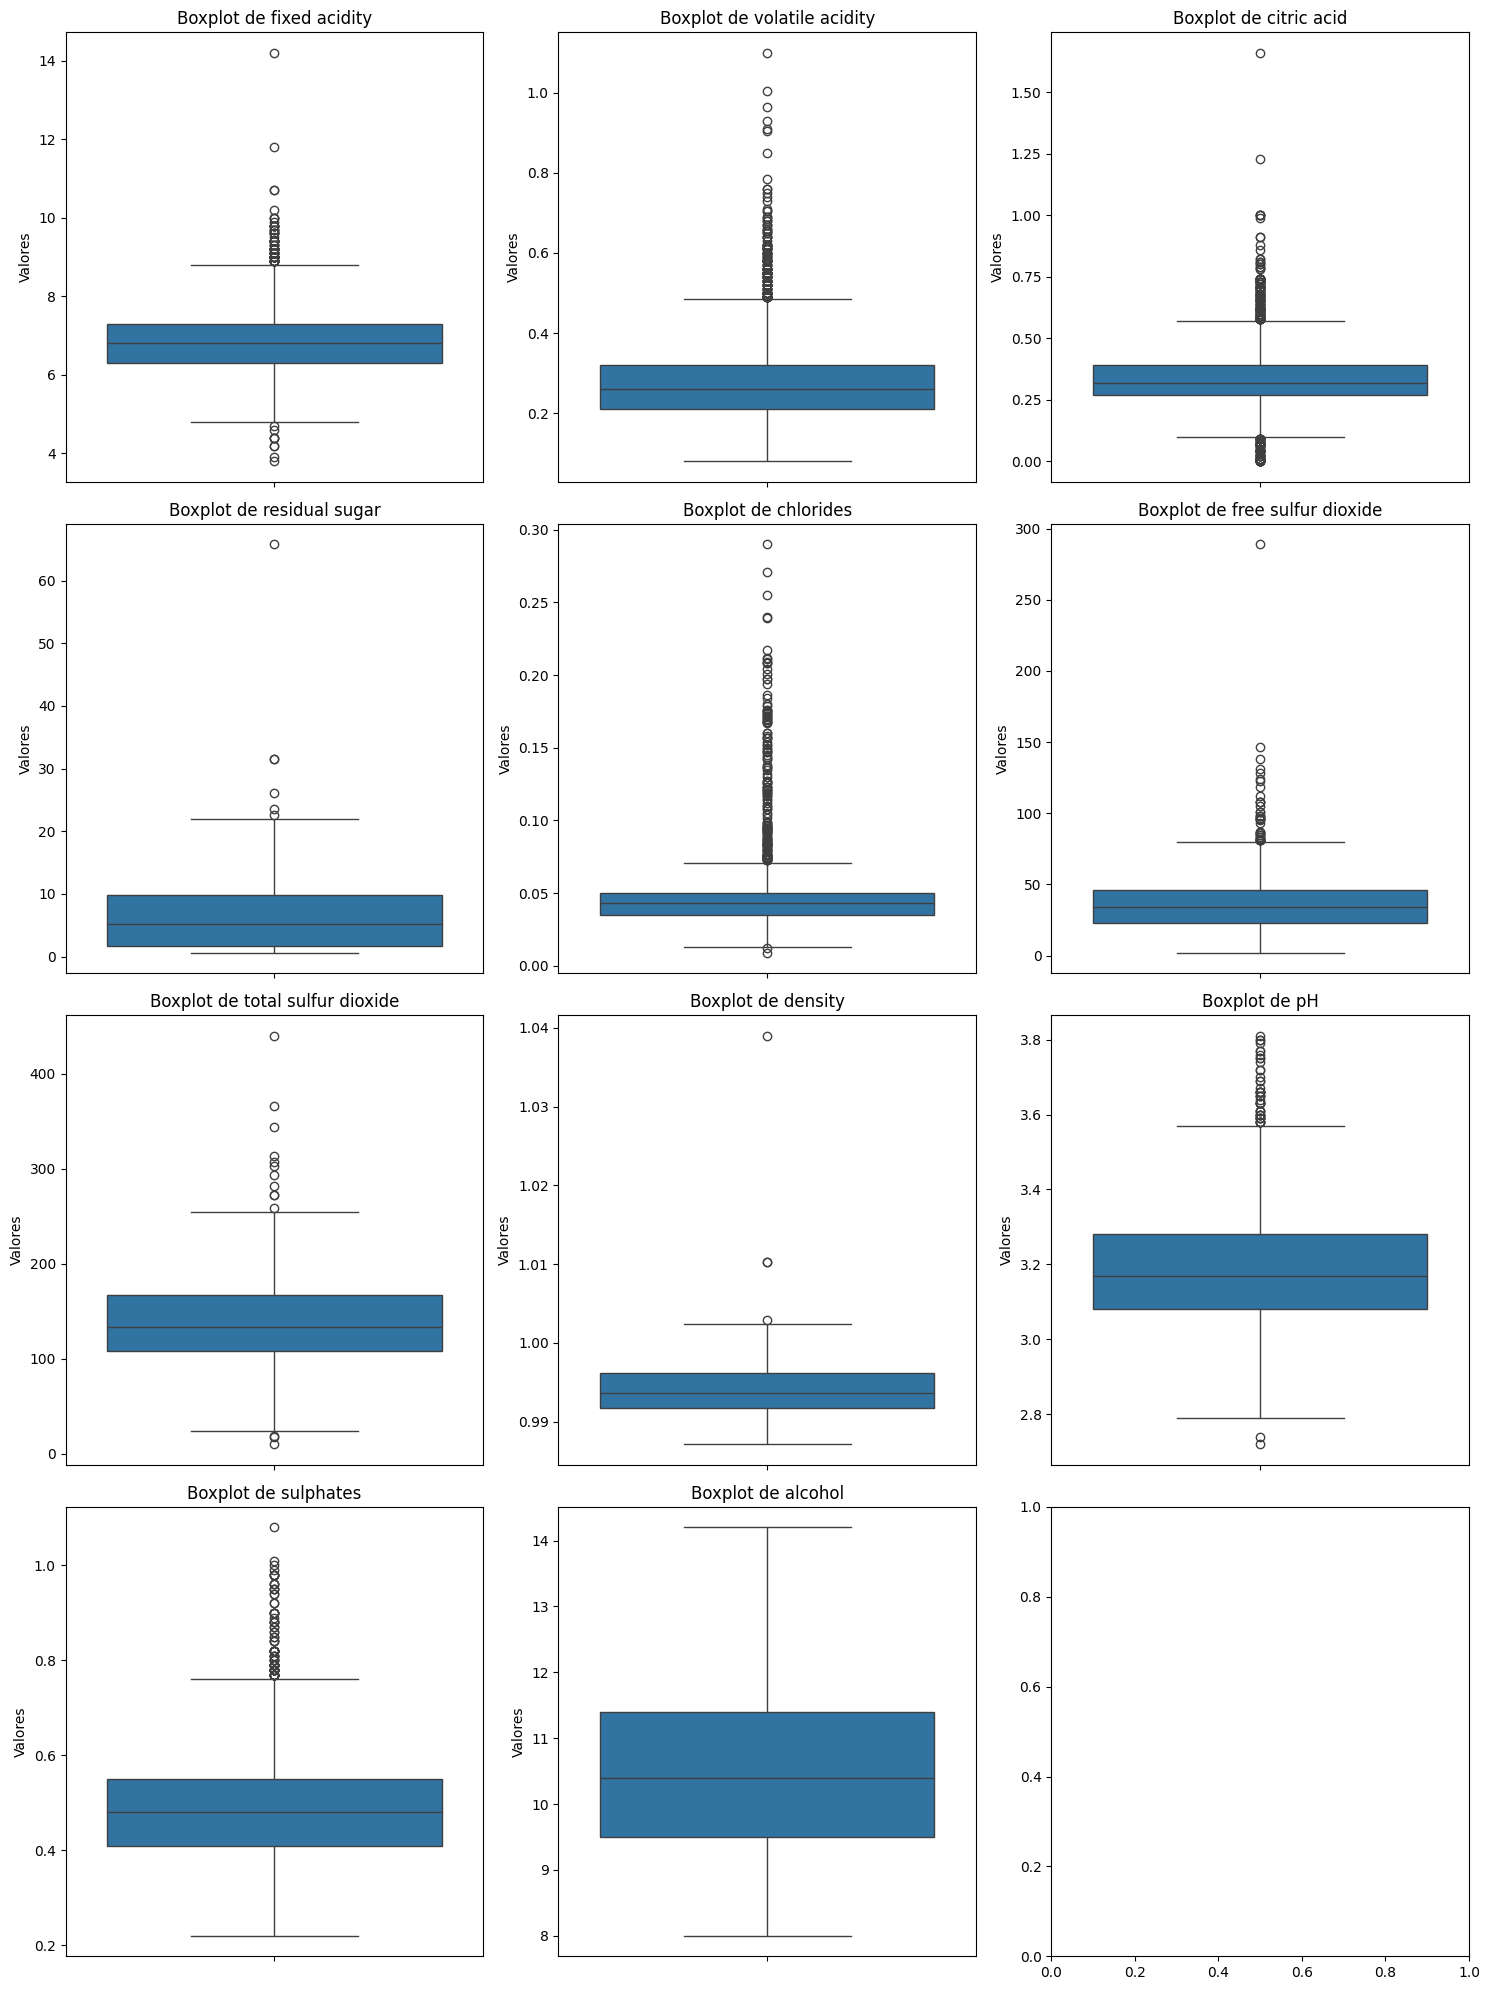

In [ ]:
#BOX PLOTS PARA BUSQUEDA DE OUTLIERS

total_plots = len(blancos.columns)
rows = (total_plots + 2) // 3
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))

for idx, column in enumerate(blancos.columns):
    ax = axes[idx // 3, idx % 3] if total_plots > 1 else axes
    sns.boxplot(y=column, data=blancos, ax=ax)
    ax.set_title(f'Boxplot de {column}')
    ax.set_ylabel('Valores')
    ax.set_xlabel(None)

plt.tight_layout()

plt.show()

<Axes: >

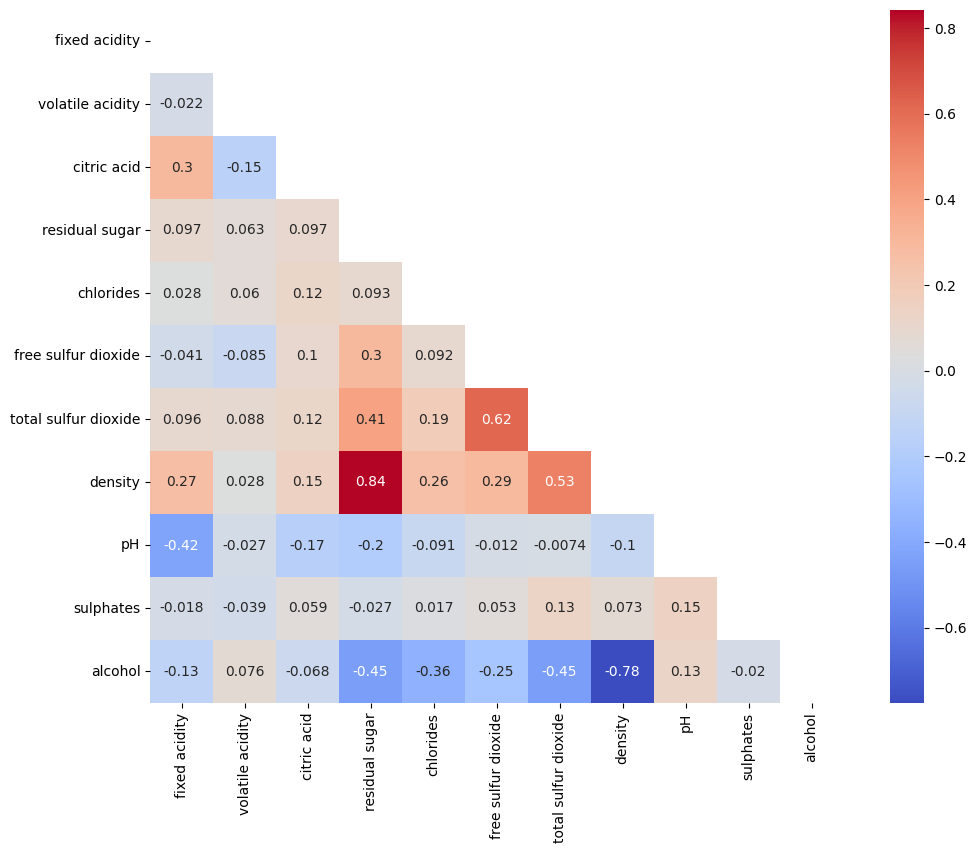

In [ ]:
corrmat = blancos.corr()
f, ax = plt.subplots(figsize=(12, 9))
mask = np.triu(np.ones_like(corrmat, dtype=bool))
sns.heatmap(corrmat, mask=mask, square=True, annot=True, cmap="coolwarm")

In [ ]:
#ESTANDARIZADO DE DATOS

scaler = StandardScaler()
blancos_scaled = scaler.fit_transform(blancos)

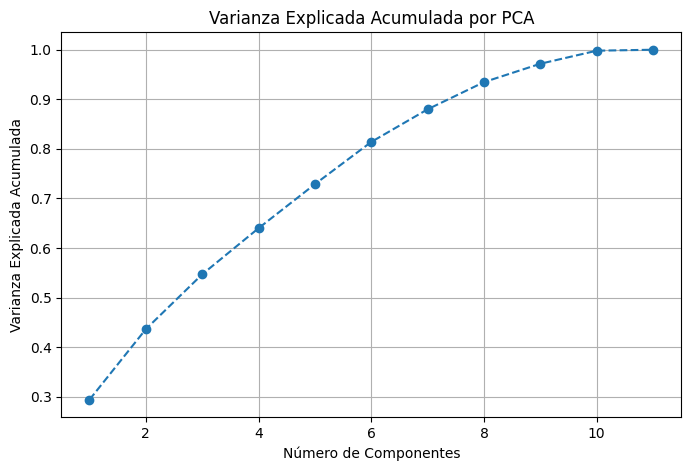

In [ ]:
# Inicializamos PCA
pca = PCA()
pca.fit(blancos_scaled)

# Calculamos la varianza explicada acumulada
varianza_acumulada = np.cumsum(pca.explained_variance_ratio_)

# Graficamos la varianza explicada acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(varianza_acumulada) + 1), varianza_acumulada, marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada por PCA')
plt.grid(True)
plt.show()

In [ ]:
#Elegimos 7 componentes por estar cercano al 90%,
pca = PCA(n_components=7)
blancos_pca = pca.fit_transform(blancos_scaled)

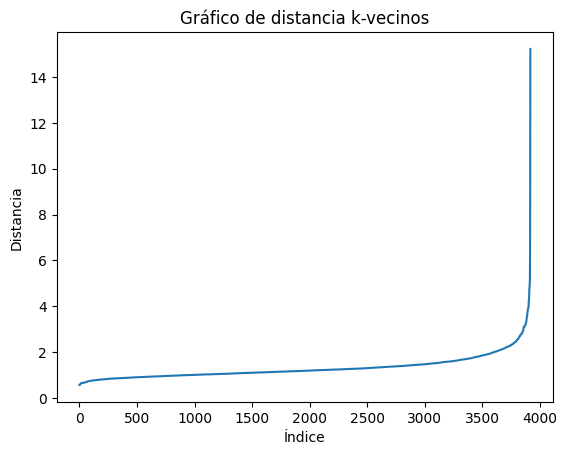

In [ ]:
# Ajustar el modelo para calcular distancias de los k-vecinos
neigh = NearestNeighbors(n_neighbors=10)
neigh.fit(blancos_pca)
distances, _ = neigh.kneighbors(blancos_pca)

# Ordenar y graficar las distancias
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.title("Gráfico de distancia k-vecinos")
plt.xlabel("Índice")
plt.ylabel("Distancia")
plt.show()

In [ ]:
#BUSQUEDA DEL MEJOR VALOR PARA DBSCAN
# Definir rangos para eps y min_samples
eps_values = np.arange(1.0, 2.5, 0.1)
min_samples_values = [8, 9, 10, 11, 12, 13, 14, 15]

# Variables para almacenar los mejores resultados
best_params = {"eps": None, "min_samples": None}
best_silhouette = -1  # El coeficiente de silueta es entre -1 y 1
best_calinski = -1

print("Probando combinaciones de parámetros...")

# Bucle para probar diferentes combinaciones
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(blancos_pca)

        # Verificar si hay al menos 2 clústeres distintos (excluyendo -1)
        unique_labels = set(labels) - {-1}  # Elimina la etiqueta de ruido (-1)
        if len(unique_labels) < 2:
            print(f"eps={eps}, min_samples={min_samples}: Solo hay un clúster válido (o todo es ruido)")
            continue

        # Calcular coeficiente de silueta (excluye outliers con etiqueta -1)
        sil_score = silhouette_score(blancos_pca[labels != -1], labels[labels != -1])

        # Calcular índice de Calinski-Harabasz (incluye todos los datos)
        calinski_score = calinski_harabasz_score(blancos_pca, labels)

        print(f"eps={eps}, min_samples={min_samples}, Silueta={sil_score:.2f}, Calinski-Harabasz={calinski_score:.2f}")

        # Actualizar el mejor resultado basado en el coeficiente de silueta
        if sil_score > best_silhouette:
            best_silhouette = sil_score
            best_params["eps"] = eps
            best_params["min_samples"] = min_samples
            best_calinski = calinski_score

print("\nMejor combinación encontrada:")
print(f"eps={best_params['eps']}, min_samples={best_params['min_samples']}")
print(f"Coeficiente de Silueta: {best_silhouette:.2f}, Índice de Calinski-Harabasz: {best_calinski:.2f}")


Probando combinaciones de parámetros...
eps=1.0, min_samples=8, Silueta=-0.30, Calinski-Harabasz=8.53
eps=1.0, min_samples=9, Silueta=-0.28, Calinski-Harabasz=9.43
eps=1.0, min_samples=10, Silueta=-0.30, Calinski-Harabasz=9.28
eps=1.0, min_samples=11, Silueta=-0.24, Calinski-Harabasz=12.54
eps=1.0, min_samples=12, Silueta=-0.23, Calinski-Harabasz=11.06
eps=1.0, min_samples=13, Silueta=-0.15, Calinski-Harabasz=14.62
eps=1.0, min_samples=14, Silueta=-0.01, Calinski-Harabasz=26.18
eps=1.0, min_samples=15, Silueta=0.16, Calinski-Harabasz=31.27
eps=1.1, min_samples=8, Silueta=-0.02, Calinski-Harabasz=25.12
eps=1.1, min_samples=9, Silueta=-0.01, Calinski-Harabasz=29.32
eps=1.1, min_samples=10, Silueta=0.25, Calinski-Harabasz=39.80
eps=1.1, min_samples=11, Silueta=0.26, Calinski-Harabasz=37.62
eps=1.1, min_samples=12: Solo hay un clúster válido (o todo es ruido)
eps=1.1, min_samples=13, Silueta=-0.00, Calinski-Harabasz=28.79
eps=1.1, min_samples=14, Silueta=-0.15, Calinski-Harabasz=21.01
eps=

In [ ]:
#INICIALIZAR DBSCAN PARA BUSQUEDA DE OUTLIERS
eps = 2  # Radio de vecindad
min_samples = 13  # Mínimo número de puntos en la vecindad para formar un clúster

# Crear y ajustar el modelo
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(blancos_pca)

# Identificar los índices de los outliers
outlier_indices = np.where(labels == -1)[0]

# Extraer los outliers
outliers = blancos_pca[outlier_indices]

print(f"Número de outliers detectados: {len(outlier_indices)}")
print("Outliers:", outliers)

Número de outliers detectados: 164
Outliers: [[ 0.82187039 -0.04700661 -2.81333493 ...  1.10914952  1.071443
   4.0090853 ]
 [ 5.17949242  1.13274348  1.55287018 ...  1.41581151  4.53159607
  -0.04163445]
 [ 1.56662192 -1.46402115  1.09167059 ... -0.03745315  2.61330698
  -0.83680368]
 ...
 [ 3.64034742 -2.38732861 -2.49138314 ...  2.10777492  3.08691273
  -1.93022406]
 [ 0.48469826  1.92808805 -0.26419817 ...  0.75978661  3.08799839
   1.10310215]
 [-2.60015836 -1.83964828  2.33375872 ...  2.5655264   0.15282187
   1.66758729]]


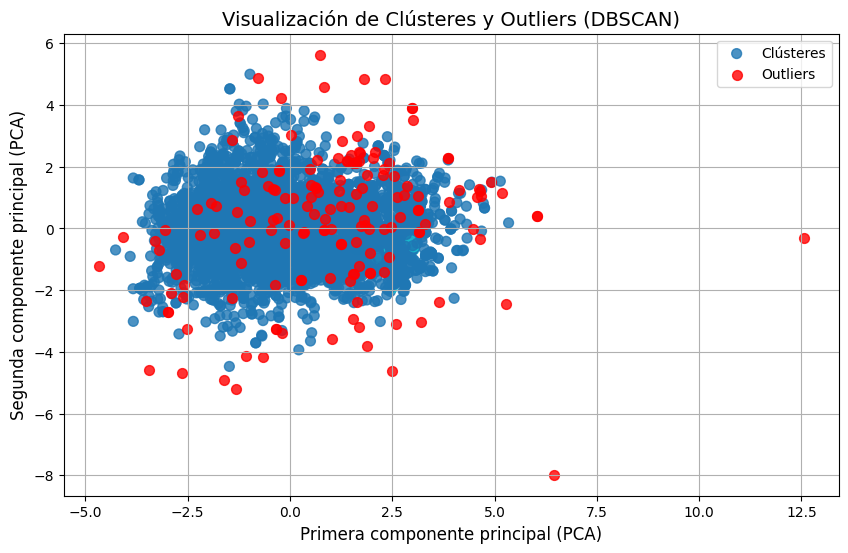

In [ ]:
#VISUALIZACION DE LOS OUTLIER DETECTADO EN 2D
# Reducir a 2 dimensiones para visualización
pca_2d = PCA(n_components=2)
blancos_pca_2d = pca_2d.fit_transform(blancos_pca)

# Ejecuta DBSCAN con los mejores parámetros
dbscan = DBSCAN(eps=2, min_samples=12)
labels = dbscan.fit_predict(blancos_pca)

# Crear una máscara para separar outliers y clústeres
outliers = (labels == -1)  # True para los outliers
clusters = ~outliers       # True para los puntos que pertenecen a clústeres

# Visualizar los datos en 2D (PCA reducido a 2 dimensiones)
plt.figure(figsize=(10, 6))

# Puntos de los clústeres
plt.scatter(blancos_pca_2d[clusters, 0], blancos_pca_2d[clusters, 1],
            c=labels[clusters], cmap='tab10', s=50, label='Clústeres', alpha=0.8)

# Puntos de los outliers
plt.scatter(blancos_pca_2d[outliers, 0], blancos_pca_2d[outliers, 1],
            c='red', s=50, label='Outliers', alpha=0.8)

plt.title("Visualización de Clústeres y Outliers (DBSCAN)", fontsize=14)
plt.xlabel("Primera componente principal (PCA)", fontsize=12)
plt.ylabel("Segunda componente principal (PCA)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Filtrar los puntos que no son outliers (etiquetas != -1)
blancos_sin_outliers = blancos_pca[labels != -1]

# Ahora `blancos_sin_outliers` contiene solo los puntos que no son outliers
print(f"Datos sin outliers: {blancos_sin_outliers.shape}")

Datos sin outliers: (3757, 7)


In [ ]:
# Método del codo para determinar el número óptimo de clústeres sin outliers
wcssb = []  # Suma de los cuadrados dentro de los clústeres
range_clusters = range(2, 30)
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(blancos_sin_outliers)
    wcssb.append(kmeans.inertia_)


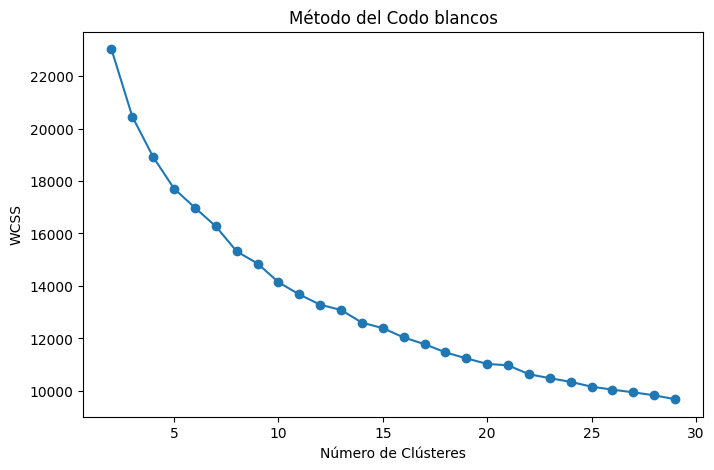

In [ ]:
# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, wcssb, marker='o')
plt.title('Método del Codo blancos')
plt.xlabel('Número de Clústeres')
plt.ylabel('WCSS')
plt.show()

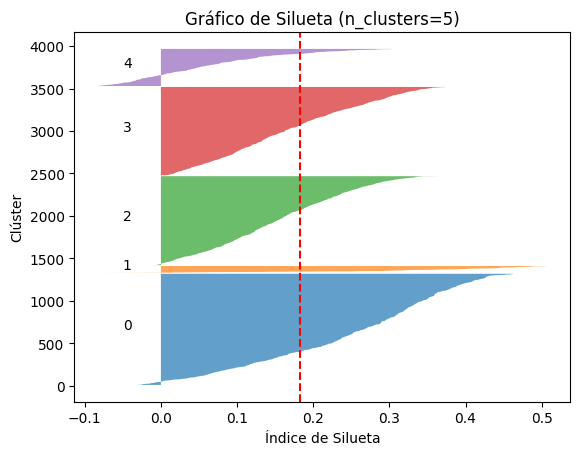

In [ ]:
# Datos para el clustering
X = blancos_pca

# Selecciona el número de clústeres
n_clusters = 5  # Cambia por el número de clústeres deseado

# Ajustar el modelo KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# Calcular las puntuaciones de silueta para cada punto
silhouette_vals = silhouette_samples(X, labels)

# Crear el Silhouette Plot
def plot_silhouette(X, labels, silhouette_vals, n_clusters):
    """
    Genera un Silhouette Plot para visualizar la calidad del clustering.
    """
    y_lower = 10
    for i in range(n_clusters):
        # Puntuaciones de silueta del clúster actual
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()
        size_cluster_i = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i

        # Rellenar el gráfico
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # Dejar espacio entre clústeres

    # Dibujar la línea del índice de silueta promedio
    avg_score = np.mean(silhouette_vals)
    plt.axvline(avg_score, color="red", linestyle="--")

    plt.xlabel("Índice de Silueta")
    plt.ylabel("Clúster")
    plt.title(f"Gráfico de Silueta (n_clusters={n_clusters})")
    plt.show()

# Llamar a la función para graficar
plot_silhouette(X, labels, silhouette_vals, n_clusters)

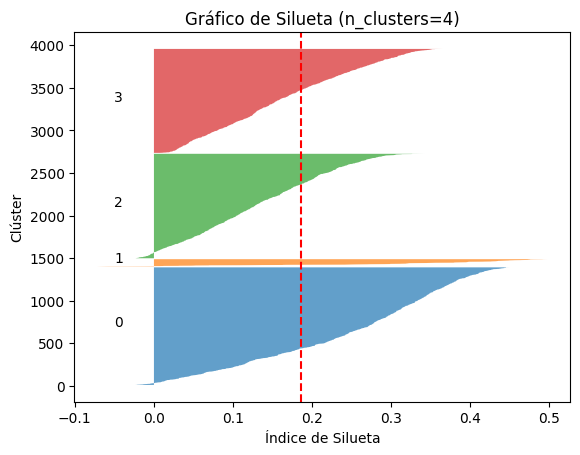

In [ ]:
# Datos para el clustering
X = blancos_pca

# Selecciona el número de clústeres
n_clusters = 4  # Cambia por el número de clústeres deseado

# Ajustar el modelo KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# Calcular las puntuaciones de silueta para cada punto
silhouette_vals = silhouette_samples(X, labels)

# Crear el Silhouette Plot
def plot_silhouette(X, labels, silhouette_vals, n_clusters):
    """
    Genera un Silhouette Plot para visualizar la calidad del clustering.
    """
    y_lower = 10
    for i in range(n_clusters):
        # Puntuaciones de silueta del clúster actual
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()
        size_cluster_i = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i

        # Rellenar el gráfico
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # Dejar espacio entre clústeres

    # Dibujar la línea del índice de silueta promedio
    avg_score = np.mean(silhouette_vals)
    plt.axvline(avg_score, color="red", linestyle="--")

    plt.xlabel("Índice de Silueta")
    plt.ylabel("Clúster")
    plt.title(f"Gráfico de Silueta (n_clusters={n_clusters})")
    plt.show()

# Llamar a la función para graficar
plot_silhouette(X, labels, silhouette_vals, n_clusters)

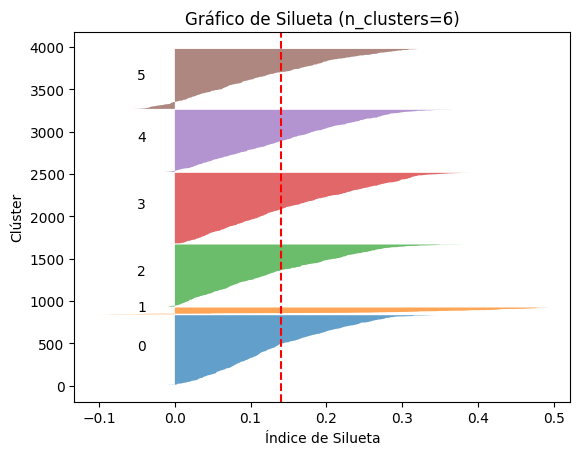

In [ ]:
# Datos para el clustering
X = blancos_pca

# Selecciona el número de clústeres
n_clusters = 6  # Cambia por el número de clústeres deseado

# Ajustar el modelo KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# Calcular las puntuaciones de silueta para cada punto
silhouette_vals = silhouette_samples(X, labels)

# Crear el Silhouette Plot
def plot_silhouette(X, labels, silhouette_vals, n_clusters):
    """
    Genera un Silhouette Plot para visualizar la calidad del clustering.
    """
    y_lower = 10
    for i in range(n_clusters):
        # Puntuaciones de silueta del clúster actual
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()
        size_cluster_i = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i

        # Rellenar el gráfico
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # Dejar espacio entre clústeres

    # Dibujar la línea del índice de silueta promedio
    avg_score = np.mean(silhouette_vals)
    plt.axvline(avg_score, color="red", linestyle="--")

    plt.xlabel("Índice de Silueta")
    plt.ylabel("Clúster")
    plt.title(f"Gráfico de Silueta (n_clusters={n_clusters})")
    plt.show()

# Llamar a la función para graficar
plot_silhouette(X, labels, silhouette_vals, n_clusters)

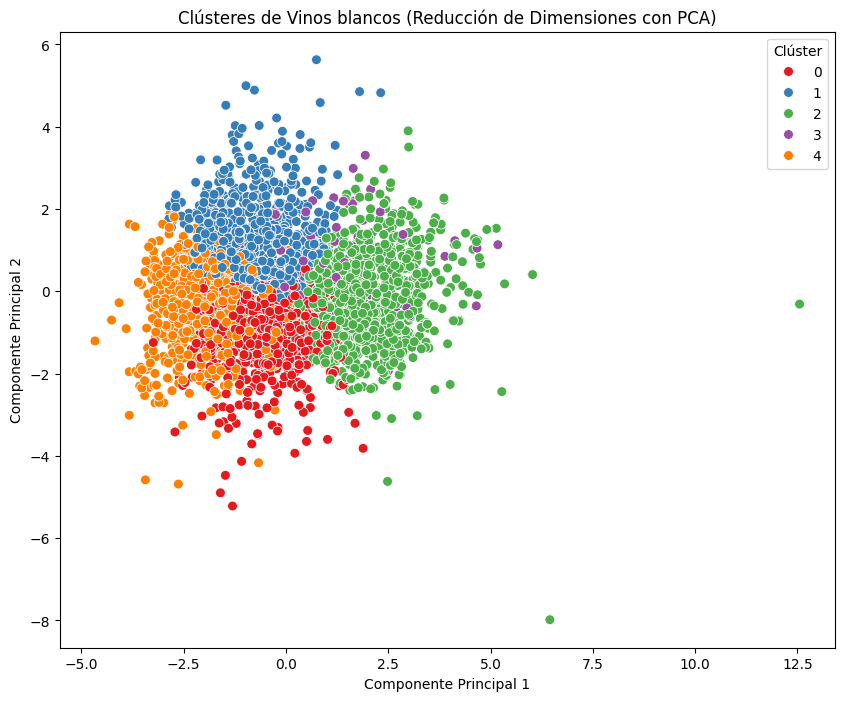

Características promedio por clúster:
         fixed acidity  volatile acidity  citric acid  residual sugar  \
Cluster                                                                 
0             6.427803          0.231891     0.308301        3.837203   
1             7.542827          0.256047     0.360723        4.060893   
2             7.017393          0.286005     0.361203       12.014286   
3             6.695181          0.320602     0.456265        4.366265   
4             6.256088          0.339683     0.276360        3.407902   

         chlorides  free sulfur dioxide  total sulfur dioxide   density  \
Cluster                                                                   
0         0.044237            35.263873            137.387882  0.993309   
1         0.040656            26.180128            115.884166  0.992838   
2         0.049098            46.673931            174.713479  0.997391   
3         0.160904            38.680723            139.789157  0.994302   


In [ ]:
# Aplicar K-means con 5 clústeres
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(blancos_pca)

# Agregar los clústeres como una nueva columna en los datos originales
blancos['Cluster'] = clusters

# Visualización de clústeres en dos dimensiones PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(blancos_pca)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=blancos['Cluster'], palette="Set1", s=50)
plt.title("Clústeres de Vinos blancos (Reducción de Dimensiones con PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Clúster")
plt.show()

# Análisis de las características promedio por clúster
cluster_means_b = blancos.groupby('Cluster').mean()
print("Características promedio por clúster:")
print(cluster_means_b)

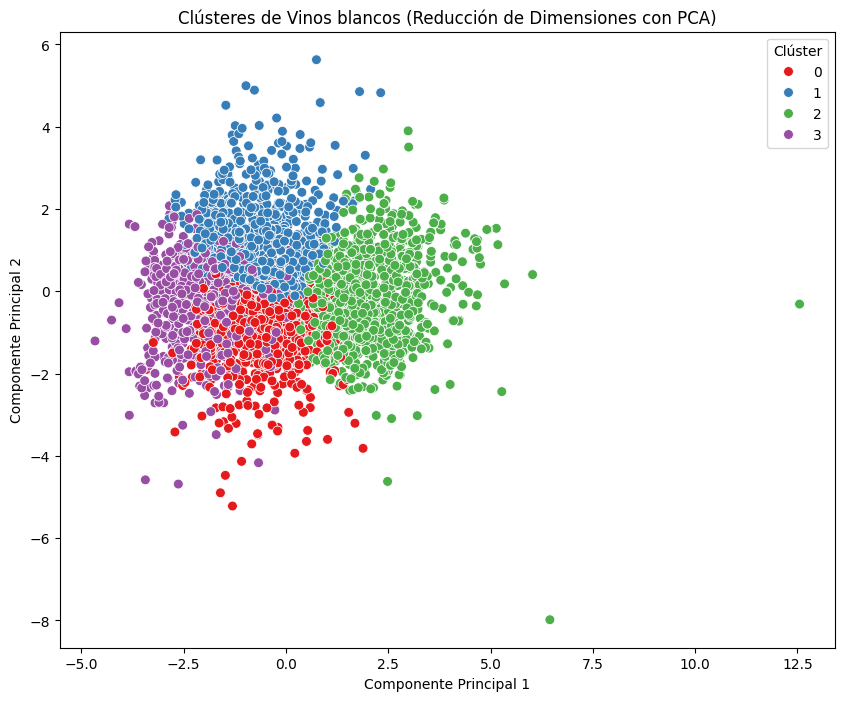

Características promedio por clúster:
         fixed acidity  volatile acidity  citric acid  residual sugar  \
Cluster                                                                 
0             6.415353          0.232706     0.307659        3.758922   
1             7.488146          0.254610     0.367730        3.991185   
2             7.002500          0.287904     0.360777       11.716038   
3             6.279948          0.341803     0.277279        3.482357   

         chlorides  free sulfur dioxide  total sulfur dioxide   density  \
Cluster                                                                   
0         0.043563            35.200463            136.814021  0.993208   
1         0.045328            26.105876            115.578521  0.992924   
2         0.053509            46.801923            174.441154  0.997277   
3         0.034855            28.139974            108.138021  0.990827   

               pH  sulphates    alcohol  
Cluster                       

In [ ]:
# Aplicar K-means con 4 clústeres
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(blancos_pca)

# Agregar los clústeres como una nueva columna en los datos originales
blancos['Cluster'] = clusters

# Visualización de clústeres en dos dimensiones PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(blancos_pca)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=blancos['Cluster'], palette="Set1", s=50)
plt.title("Clústeres de Vinos blancos (Reducción de Dimensiones con PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Clúster")
plt.show()

# Análisis de las características promedio por clúster
cluster_means_b = blancos.groupby('Cluster').mean()
print("Características promedio por clúster:")
print(cluster_means_b)

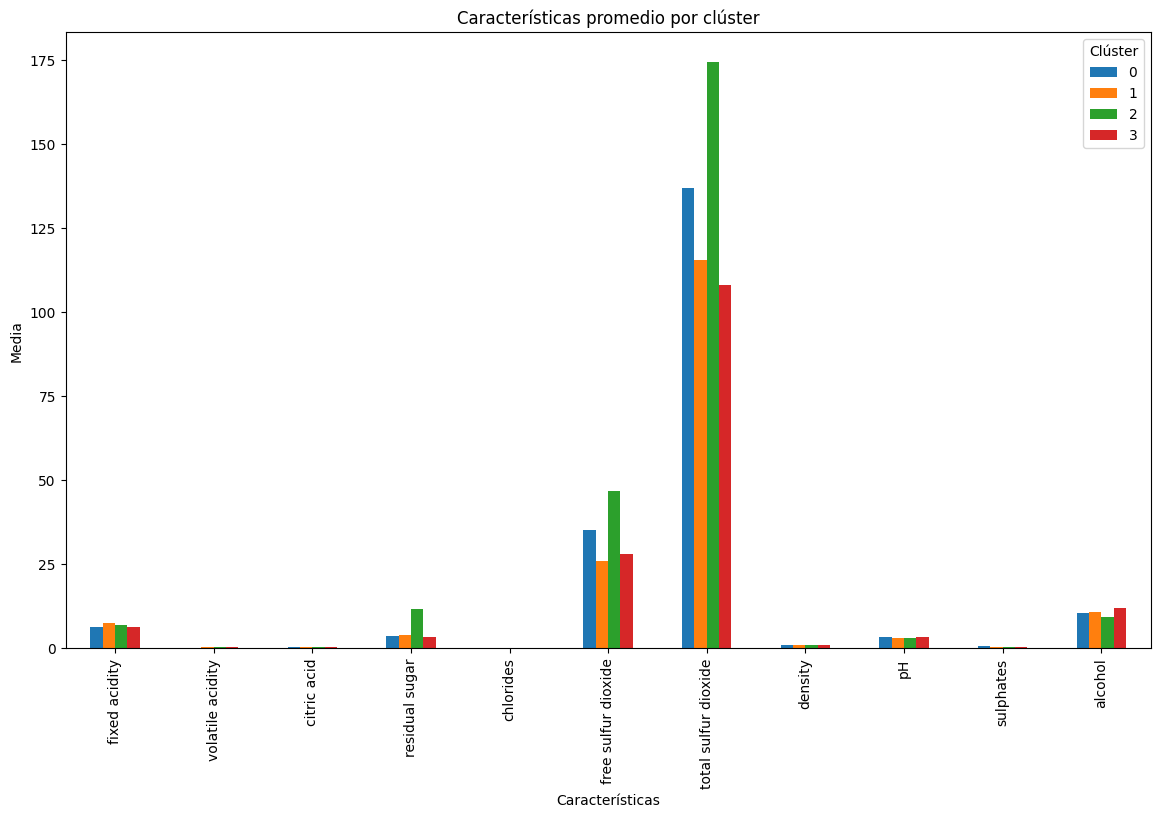

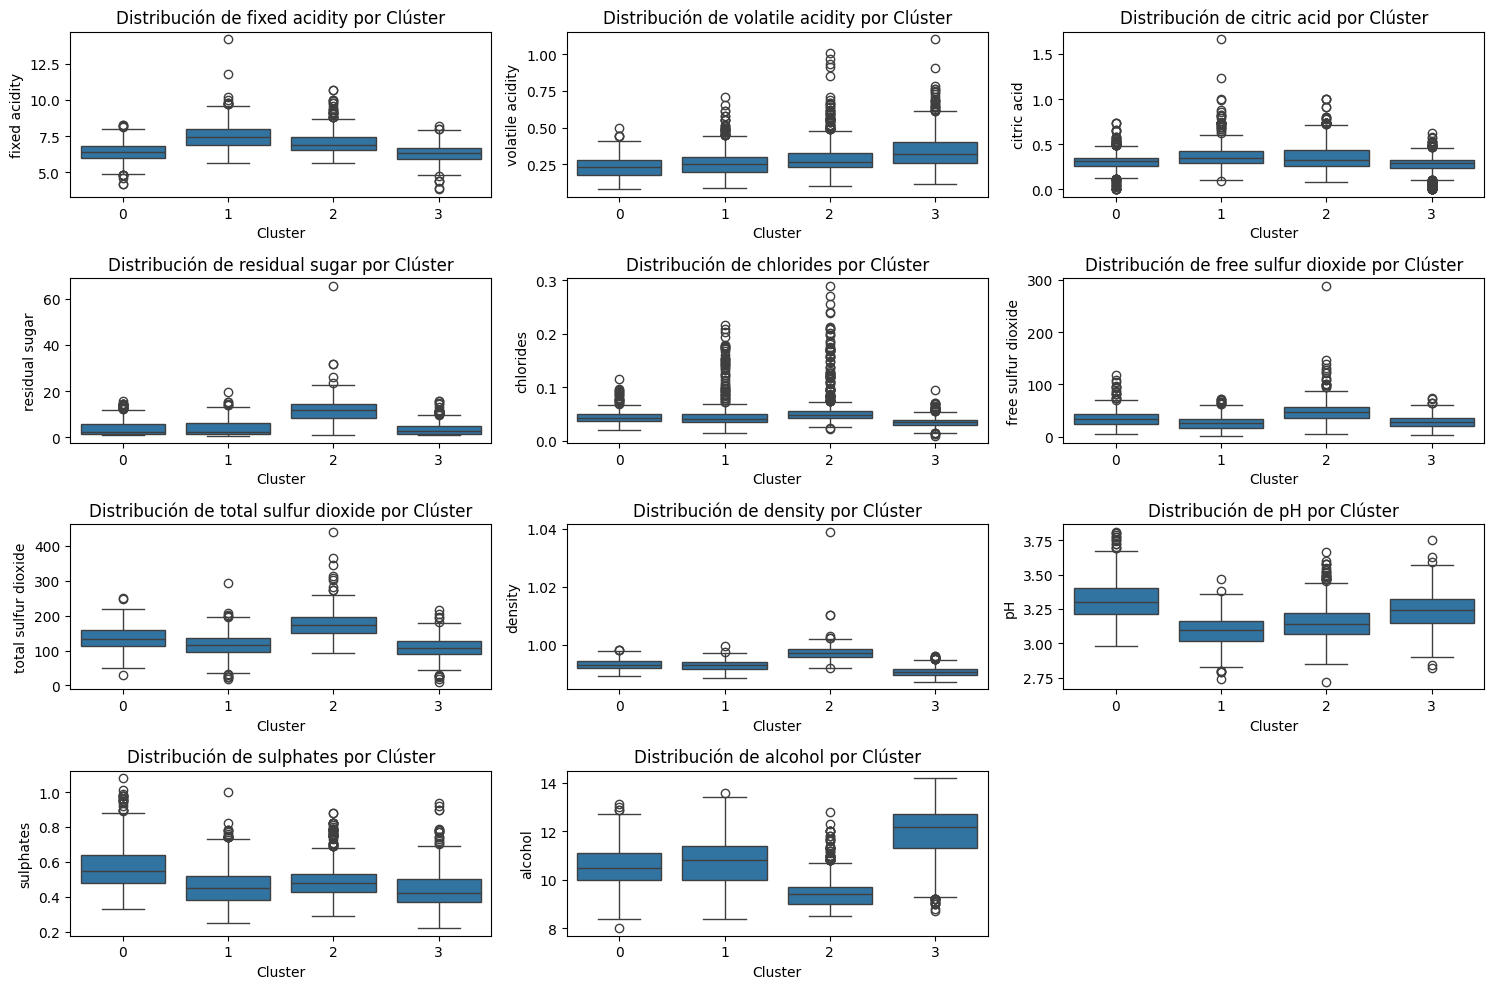

In [ ]:
# Gráfico de barras de las características promedio por clúster
cluster_means_b.T.plot(kind='bar', figsize=(14, 8))
plt.title("Características promedio por clúster")
plt.ylabel("Media")
plt.xlabel("Características")
plt.legend(title="Clúster")
plt.show()

# Gráfico de cajas para ver la distribución de cada característica por clúster
plt.figure(figsize=(15, 10))
for i, column in enumerate(blancos.columns[:-1], 1):  # Excluyendo la columna 'Cluster'
    plt.subplot(4, 3, i)  # Ajusta según el número de características
    sns.boxplot(data=blancos, x='Cluster', y=column)
    plt.title(f"Distribución de {column} por Clúster")
plt.tight_layout()
plt.show()

In [ ]:
def clustering_blancos(df,):

    # Crear el modelo KMeans
    kmeans = KMeans(n_clusters=4, random_state=0)

    # Ajustar el modelo y predecir los clústeres
    clusters = kmeans.fit_predict(df)

    # Agregar los clústeres como una nueva columna
    df['Cluster'] = clusters

    return df

blancos_clustered = clustering_blancos(blancos)
print(blancos_clustered)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               8.0              0.25         0.27            9.70      0.036   
1               8.7              0.34         0.46           13.80      0.055   
2               9.0              0.31         0.49            6.90      0.034   
3               6.7              0.37         0.25            2.50      0.028   
4               7.0              0.28         0.32            7.75      0.032   
...             ...               ...          ...             ...        ...   
3913            6.3              0.27         0.25            5.80      0.038   
3914            6.2              0.32         0.12            4.80      0.054   
3915            6.7              0.15         0.38            1.70      0.037   
3916            6.9              0.25         0.30            4.10      0.054   
3917            7.0              0.36         0.32           10.50      0.045   

      free sulfur dioxide  